In [1]:
from typing import TypedDict, Annotated, Sequence  # Annotated helps in creating metadata for the types

from langchain_core.messages import BaseMessage,ToolMessage,SystemMessage
from langchain_core.tools import tool
from langchain_google_genai import ChatGoogleGenerativeAI

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode

import os
from dotenv import load_dotenv
load_dotenv()

if "GOOGLE_API_KEY" not in os.environ:
    os.environ["GOOGLE_API_KEY"] = os.getenv("GEMINI_API_KEY")

In [2]:
class State(TypedDict): 
    ### annotated provides metadata for the datatype
    ### sequence accepts any type of sequenctial primitive data types like list, tuple and strings (not set since it is not ordered and not dict since it is key:value based and not index based)
    ### add_messages adds the messages to the state automatically instead of having to append them in the graph action logic
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [16]:
@tool
def add(a:int,b:int) -> int:
    """this function adds two numbers"""
    return a+b

@tool 
def subtract(a:int,b:int) -> int:
    """this function subtracts two numbers"""
    return a-b

@tool
def multiply(a:int,b:int) -> int:
    """this function multiplies two numbers"""
    return a*b

@tool
def divide(a:float,b:float) -> float:
    """this function divides two numbers"""
    return a/b

In [17]:
# for adding multiple tools
tools = [add,subtract,multiply,divide]

# intialize the model and bind the tools to it
llm = ChatGoogleGenerativeAI(
    model = "gemini-2.0-flash",
    temperature = 0
).bind_tools(tools=tools)

In [18]:
### actions
def model_call(state:State) -> State:
    system_prompt = SystemMessage(
        content="You are a helpful assistant, please answer the query to the best of your ability."
    )
    response = llm.invoke([system_prompt] + state['messages'])
    return {"messages": [response]} ### since add_message is defined in the annotaion it will update the state automatically instead of replacing it

def should_continue(state:State)-> State:
    last_message = state['messages'][-1]
    if not last_message.tool_calls:
        return "end"
    else:
        return "continue"

In [19]:
agent = StateGraph(State)

agent.add_node("agent_query",model_call)

tool_node = ToolNode(tools=tools)
agent.add_node("tool_node",tool_node)

agent.add_edge(START,"agent_query")
agent.add_conditional_edges(
    "agent_query",
    should_continue,
    {
        #edge:node
        "end":END,
        "continue":"tool_node"
    }
)
agent.add_edge("tool_node","agent_query")

app = agent.compile()

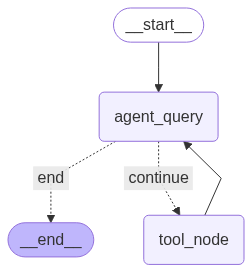

In [20]:
from IPython.display import Image
display(Image(app.get_graph().draw_mermaid_png()))

In [21]:
def print_stream(stream):
    for s in stream:
        message = s['messages'][-1]
        if isinstance(message, tuple):
            print(message)
        else: 
            message.pretty_print()

In [23]:
inputs = {"messages": ("user","what is 8+8, 9-2, 10*21 and 16/2 also tell me a joke")}
print_stream(app.stream(inputs,stream_mode="values"))

================================ Human Message =================================

what is 8+8, 9-2, 10*21 and 16/2 also tell me a joke
================================== Ai Message ==================================
Tool Calls:
  add (7e97083a-37b6-452c-9a63-4ab4a752822e)
 Call ID: 7e97083a-37b6-452c-9a63-4ab4a752822e
  Args:
    b: 8.0
    a: 8.0
  subtract (edc0b371-4510-4123-b483-cde6bde02f25)
 Call ID: edc0b371-4510-4123-b483-cde6bde02f25
  Args:
    b: 2.0
    a: 9.0
  multiply (503bc454-38d8-4bb8-b96b-175c923a43c3)
 Call ID: 503bc454-38d8-4bb8-b96b-175c923a43c3
  Args:
    b: 21.0
    a: 10.0
  divide (086d78d7-efee-4f79-a92c-4a942b391705)
 Call ID: 086d78d7-efee-4f79-a92c-4a942b391705
  Args:
    b: 2.0
    a: 16.0
================================= Tool Message =================================
Name: divide

8.0
================================== Ai Message ==================================

8+8 = 16, 9-2 = 7, 10*21 = 210 and 16/2 = 8.

Here's a joke for you: Why don't scientis